# TDoA Drone Localization (RF) — Kherson, Ukraine
This notebook demonstrates a simple Time Difference of Arrival (TDoA) multilateration simulation using GPS coordinates, least-squares estimation, and an OpenStreetMap basemap.

## Example output (screenshot)
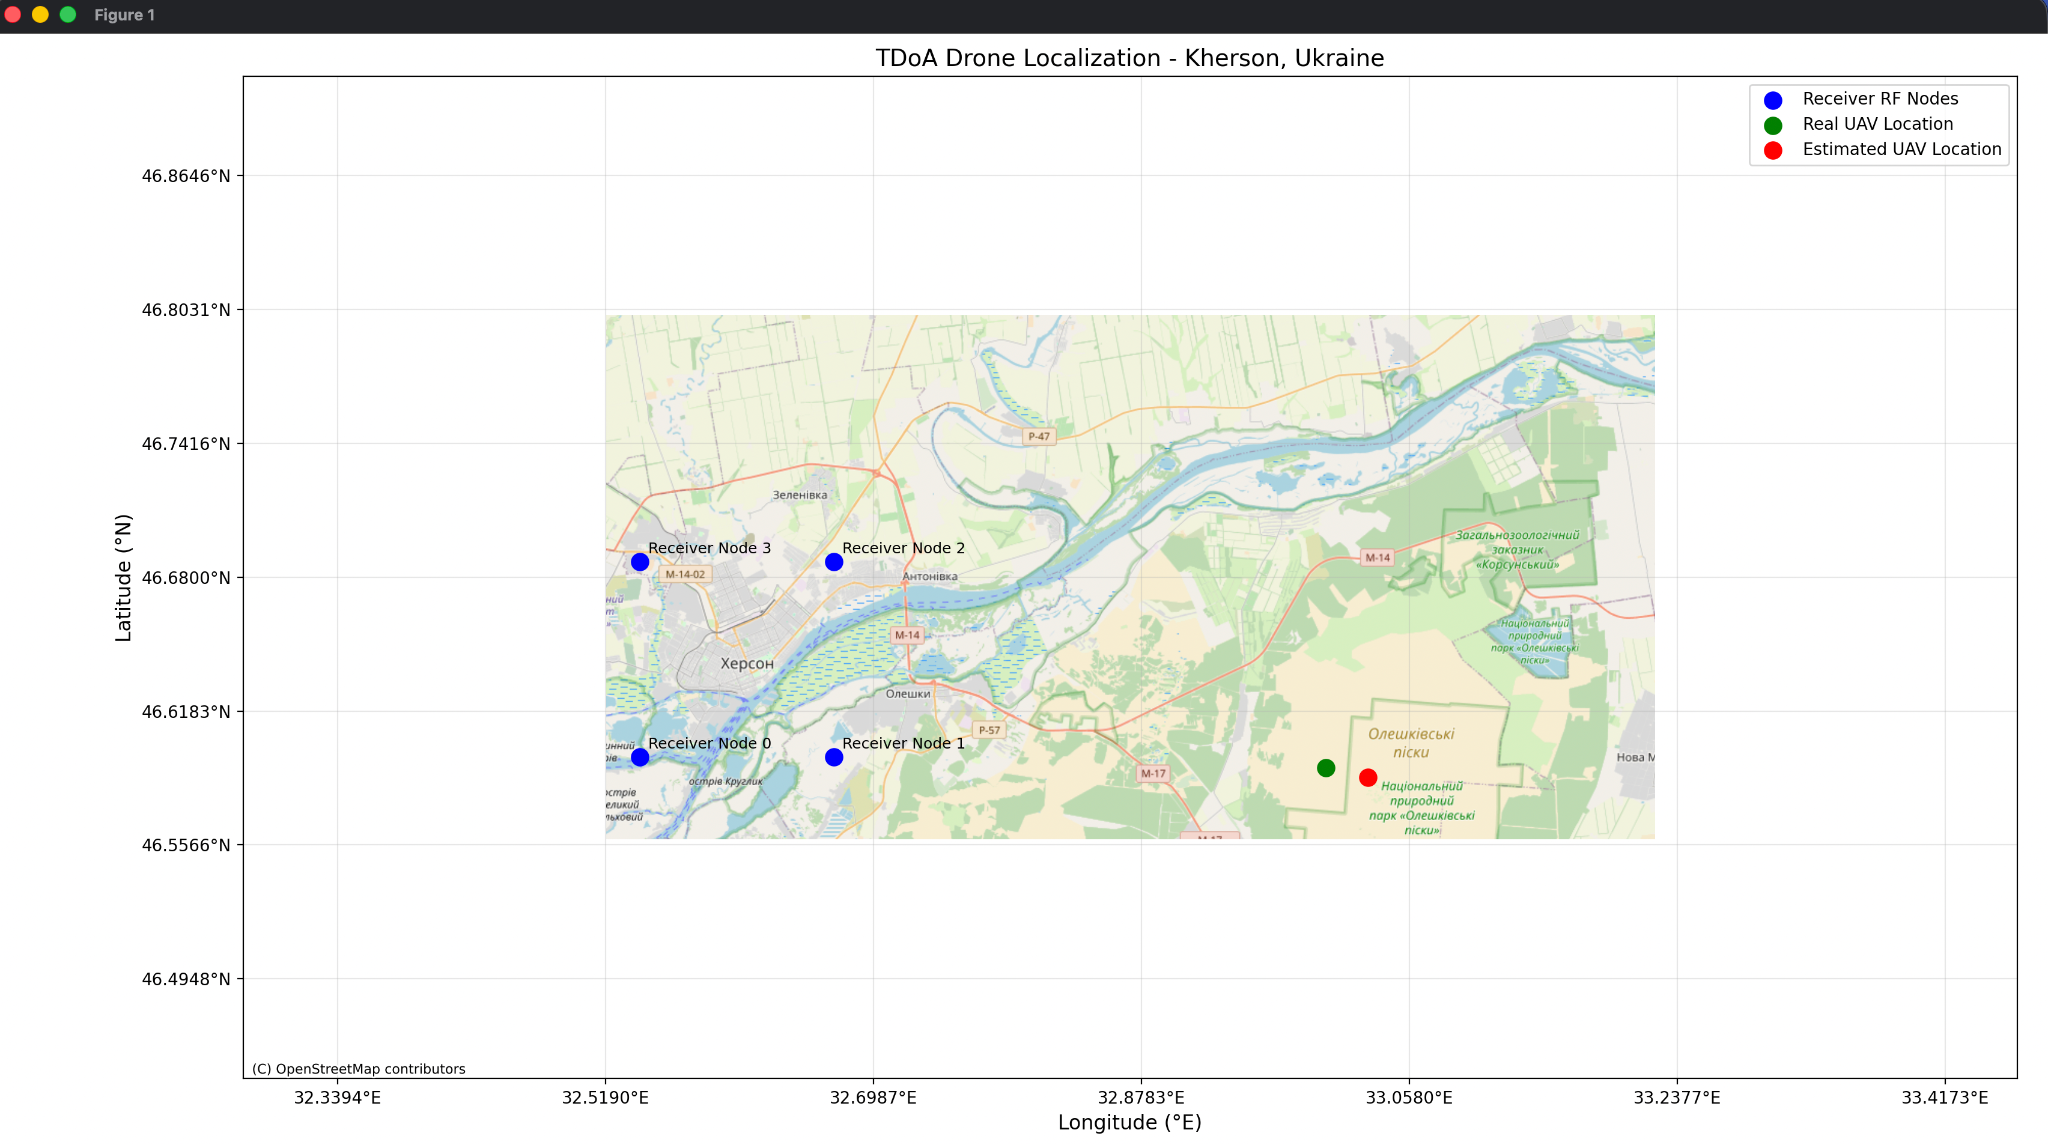

## Setup
Install dependencies (if needed):

```bash
pip install numpy scipy matplotlib pyproj contextily
```

Note: `contextily` downloads map tiles from OpenStreetMap providers; an internet connection is required for the basemap layer.


In [ ]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import math
import contextily as ctx
from pyproj import Transformer
from matplotlib.ticker import FuncFormatter

# Speed of light (m/s)
c = 3e8

# Earth's radius in meters
R_EARTH = 6371000

# -----------------------------
# GPS Distance Calculation (Haversine Formula)
# -----------------------------
def geo_distance(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = (math.sin(dlat / 2)**2 + 
         math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2)
    c_dist = 2 * math.asin(math.sqrt(a))
    
    return R_EARTH * c_dist

def geo_distance_array(pos_lat, pos_lon, nodes_lat, nodes_lon):
    distances = []
    for i in range(len(nodes_lat)):
        dist = geo_distance(pos_lat, pos_lon, nodes_lat[i], nodes_lon[i])
        distances.append(dist)
    return np.array(distances)

# -----------------------------
# 1. Define Node Positions (GPS coordinates)
# -----------------------------
# Kherson center: approximately 46.642099° N, 32.606996° E
# Creating a square ~10km apart around Kherson
CENTER_LAT = 46.642099
CENTER_LON = 32.606996

# For ~10km spacing at this latitude:
# 1° latitude ≈ 111 km, so 10km ≈ 0.09°
# 1° longitude ≈ 111 * cos(46.6°) ≈ 76 km, so 10km ≈ 0.13°
SPACING_LAT = 0.09  # degrees (~10km)
SPACING_LON = 0.13  # degrees (~10km)

# Define 4 nodes in a square formation
nodes_lat = np.array([
    CENTER_LAT - SPACING_LAT/2,  # SW
    CENTER_LAT - SPACING_LAT/2,  # SE
    CENTER_LAT + SPACING_LAT/2,  # NE
    CENTER_LAT + SPACING_LAT/2   # NW
])

nodes_lon = np.array([
    CENTER_LON - SPACING_LON/2,  # SW
    CENTER_LON + SPACING_LON/2,  # SE
    CENTER_LON + SPACING_LON/2,  # NE
    CENTER_LON - SPACING_LON/2   # NW
])

num_nodes = len(nodes_lat)

print("RF Receiver Nodes (GPS coordinates):")
for i in range(num_nodes):
    print(f"  Node {i}: {nodes_lat[i]:.6f}° N, {nodes_lon[i]:.6f}° E")

# -----------------------------
# 2. Define Drone Position (~30km away from center)
# -----------------------------
# Let's place the drone approximately 30km east and slightly south of Kherson center
OBJECT_OFFSET_LAT = -0.05  # degrees (~5.5 km south, 1° lat ≈ 111 km)
OBJECT_OFFSET_LON = 0.395  # degrees (~30 km east, 1° lon ≈ 76 km)

true_pos_lat = CENTER_LAT + OBJECT_OFFSET_LAT
true_pos_lon = CENTER_LON + OBJECT_OFFSET_LON

print(f"\nTrue Drone Position: {true_pos_lat:.6f}° N, {true_pos_lon:.6f}° E")

# -----------------------------
# 3. Generate Arrival Times
# -----------------------------
MEASUREMENT_NOISE_STD_DEV = 50e-9 # 50ns

def generate_toa(nodes_lat, nodes_lon, pos_lat, pos_lon, sigma_t=MEASUREMENT_NOISE_STD_DEV):
    distances = geo_distance_array(pos_lat, pos_lon, nodes_lat, nodes_lon)
    toa = distances / c
    noise = np.random.normal(0, sigma_t, size=len(toa))
    return toa + noise

toa = generate_toa(nodes_lat, nodes_lon, true_pos_lat, true_pos_lon)

# -----------------------------
# 4. Compute TDoA (reference = node 0)
# -----------------------------
ref = 0
tdoa = toa - toa[ref]
tdoa = tdoa[1:]  # remove reference
nodes_tdoa_lat = nodes_lat[1:]
nodes_tdoa_lon = nodes_lon[1:]

# -----------------------------
# 5. TDoA Residual Function
# -----------------------------
def tdoa_residual(x, nodes_lat, nodes_lon, tdoa, ref_lat, ref_lon):
    pos_lat, pos_lon = x[0], x[1]
    d_ref = geo_distance(pos_lat, pos_lon, ref_lat, ref_lon)
    residuals = []
    for i in range(len(nodes_lat)):
        d_i = geo_distance(pos_lat, pos_lon, nodes_lat[i], nodes_lon[i])
        residuals.append((d_i - d_ref) - c * tdoa[i])
    return residuals

# -----------------------------
# 6. Solve Using Least Squares
# -----------------------------
# Initial guess: center of all nodes
x0 = np.array([np.mean(nodes_lat), np.mean(nodes_lon)])

solution = least_squares(
    tdoa_residual,
    x0,
    args=(nodes_tdoa_lat, nodes_tdoa_lon, tdoa, nodes_lat[ref], nodes_lon[ref])
)

estimated_pos_lat = solution.x[0]
estimated_pos_lon = solution.x[1]

# -----------------------------
# 7. Calculate Error
# -----------------------------
error_distance = geo_distance(
    true_pos_lat, true_pos_lon,
    estimated_pos_lat, estimated_pos_lon
)

print(f"\nEstimated Drone Position: {estimated_pos_lat:.6f}° N, {estimated_pos_lon:.6f}° E")
print(f"Localization Error: {error_distance:.2f} meters ({error_distance/1000:.2f} km)")

# -----------------------------
# 8. Plot
# -----------------------------
plt.figure(figsize=(10, 10))
ax = plt.gca()

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
inv_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Transform all points to Web Mercator
all_lons = np.array([*nodes_lon, true_pos_lon, estimated_pos_lon])
all_lats = np.array([*nodes_lat, true_pos_lat, estimated_pos_lat])
all_x, all_y = transformer.transform(all_lons, all_lats)

# Set extent with a little padding, then add the basemap
pad = 2000  # meters
ax.set_xlim(float(all_x.min() - pad), float(all_x.max() + pad))
ax.set_ylim(float(all_y.min() - pad), float(all_y.max() + pad))
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857")

# Plot transformed points on top of the basemap
nodes_x, nodes_y = transformer.transform(nodes_lon, nodes_lat)
true_x, true_y = transformer.transform([true_pos_lon], [true_pos_lat])
est_x, est_y = transformer.transform([estimated_pos_lon], [estimated_pos_lat])

ax.scatter(nodes_x, nodes_y, c='blue', s=100, label='Receiver RF Nodes', zorder=3)
ax.scatter(true_x, true_y, c='green', s=100, label='Real UAV Location', zorder=3)
ax.scatter(est_x, est_y, c='red', s=100, label='Estimated UAV Location', zorder=3)

# Add labels for nodes
for i in range(num_nodes):
    x_i, y_i = transformer.transform([nodes_lon[i]], [nodes_lat[i]])
    ax.annotate(f'Receiver Node {i}', (x_i[0], y_i[0]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Format axes as GEO lon/lat (degrees) even though the basemap uses Web Mercator meters.
def _fmt_lon(x, _pos):
    lon, _lat = inv_transformer.transform(x, ax.get_ylim()[0])
    return f"{lon:.4f}°E"

def _fmt_lat(y, _pos):
    _lon, lat = inv_transformer.transform(ax.get_xlim()[0], y)
    return f"{lat:.4f}°N"

ax.xaxis.set_major_formatter(FuncFormatter(_fmt_lon))
ax.yaxis.set_major_formatter(FuncFormatter(_fmt_lat))

plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.title("TDoA Drone Localization - Kherson, Ukraine", fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Key parameters to tune
- `MEASUREMENT_NOISE_STD_DEV`: timing noise (seconds). Example: 50 ns.
- Node geometry (`SPACING_LAT`, `SPACING_LON`): affects dilution of precision.
- Drone offset (`OBJECT_OFFSET_LAT`, `OBJECT_OFFSET_LON`): sets scenario distance.

If you want the notebook to be fully offline, remove `contextily` and plot without the basemap.
